# Импорт библиотек

In [2]:
import os
import re
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split, GridSearchCV


pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# Импорт данных

## Импорт

In [5]:
path = 

In [6]:
total_scores = pd.read_csv(path + 'total_scores.csv')
tour_scores = pd.read_csv(path + 'tournament_scores.csv')
tour = pd.read_csv(path + 'tournaments.csv')
units = pd.read_csv(path + 'units.csv')
scores = pd.read_csv(path + 'scores.csv')

## Проверка загрузки данных

In [8]:
total_scores.sample(3)

,id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str
18210,6009,268,21,47.33,66.04,110.83,46.79,0.0,8,6,Произвольная программа,< Недокрученный прыжок << Пониженный прыжок ! ...,5,176.15,NaN
1459,443294,9679,5859,24.09,33.82,56.41,23.59,-1.0,4,33,Произвольная программа,* Недопустимый элемент q Прыжок приземлён в че...,33,89.59,33
9047,304463,345,3239,31.05,32.13,69.88,37.75,0.0,3,2,Короткая программа,x Надбавка за прыжки во второй половине програ...,2,205.16,NaN


In [9]:
tour_scores.sample(3)

,id,total_score_id,title,decrease,base_score,goe,avg_score
43442,50996,9428,LSp4,NaN,2.7,0.49,3.19
5191,5519,3902,CSSp,NaN,0.0,0.00,0.00
15667,19627,5563,3Sq,q,0.0,-0.43,4.30


In [10]:
tour.sample(3)

,id,date_start,date_end,origin_id
54,74,2091-02-02,2091-02-03,1.0
114,6866,2092-02-19,2092-02-21,0.0
40,43,2091-03-24,2091-03-25,2.0


In [11]:
units.sample(3)

,id,color,school_id
4461,9896,lime,20.0
4165,2457,green,198.0
695,3437,green,NaN


# EDA

In [13]:
def custom_eda(DataFrame):
    print('5 случайных строк')
    print()
    display(DataFrame.sample(5))
    print('_______________________________________________________')
    print()
    print('Общая информация по таблице:')
    print()
    display(DataFrame.info())
    print('_______________________________________________________')
    print()
    print('Описательная статистика таблицы')
    print()
    display(DataFrame.describe())
    print('_______________________________________________________')
    print()
    print('Количество пропущенных значений')
    print()
    print(DataFrame.isna().mean())
    print('_______________________________________________________')
    print()

## Таблица total_scores

In [15]:
custom_eda(total_scores)

5 случайных строк



,id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str
2515,444162,333,267,35.39,32.15,64.30,33.15,-1.0,24,17,Короткая программа,q Прыжок приземлён в четверть ! Неясное ребро ...,14,196.10,14
15475,12016,9465,74,46.51,48.49,91.20,43.71,0.0,4,15,Произвольная программа,q Прыжок приземлён в четверть < Недокрученный ...,16,146.00,NaN
18148,14237,156,83,4.60,21.16,24.18,4.02,0.0,7,29,Произвольная программа,q Прыжок приземлён в четверть << Пониженный пр...,29,24.18,NaN
5269,5338,755,17,38.57,41.92,76.59,35.67,0.0,9,21,Произвольная программа,< Недокрученный прыжок x Надбавка за прыжки во...,20,119.33,NaN
16791,458712,1550,7112,27.52,23.39,54.00,30.61,0.0,16,10,Короткая программа,x Надбавка за прыжки во второй половине програ...,15,147.79,15


_______________________________________________________

Общая информация по таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21301 entries, 0 to 21300
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21301 non-null  int64  
 1   unit_id              21301 non-null  int64  
 2   tournament_id        21301 non-null  int64  
 3   base_score           21301 non-null  float64
 4   components_score     21301 non-null  float64
 5   total_score          21301 non-null  float64
 6   elements_score       21301 non-null  float64
 7   decreasings_score    21301 non-null  float64
 8   starting_place       21301 non-null  int64  
 9   place                21301 non-null  int64  
 10  segment_name         21284 non-null  object 
 11  info                 20720 non-null  object 
 12  overall_place        21301 non-null  int64  
 13  overall_total_score  21284 non-null  float64
 14 

None

_______________________________________________________

Описательная статистика таблицы



,id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,overall_place,overall_total_score
count,21301.000000,21301.000000,21301.000000,21301.000000,21301.000000,21301.000000,21301.000000,21301.000000,21301.000000,21301.000000,21301.000000,21284.000000
mean,247946.268156,2342.803859,3146.281254,27.809781,31.324416,60.410021,27.836501,-0.240998,10.962819,10.619924,10.118117,117.443380
std,218940.086177,4370.220096,3279.412969,16.337113,17.330241,33.598123,17.745763,0.577598,8.352286,8.062790,8.003904,66.330049
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,0.000000,0.000000,0.000000
25%,9835.000000,418.000000,49.000000,15.560000,20.420000,35.880000,14.880000,0.000000,5.000000,4.000000,4.000000,69.315000
50%,442628.000000,1233.000000,267.000000,24.490000,26.660000,52.630000,24.270000,0.000000,9.000000,9.000000,8.000000,119.660000
75%,450362.000000,2217.000000,6859.000000,35.110000,41.600000,75.720000,35.910000,0.000000,15.000000,15.000000,15.000000,168.700000
max,463639.000000,35024.000000,7117.000000,94.420000,95.900000,201.650000,112.420000,0.000000,54.000000,50.000000,50.000000,323.050000


_______________________________________________________

Количество пропущенных значений

id                     0.000000
unit_id                0.000000
tournament_id          0.000000
base_score             0.000000
components_score       0.000000
total_score            0.000000
elements_score         0.000000
decreasings_score      0.000000
starting_place         0.000000
place                  0.000000
segment_name           0.000798
info                   0.027276
overall_place          0.000000
overall_total_score    0.000798
overall_place_str      0.492324
dtype: float64
_______________________________________________________



In [16]:
total_scores.value_counts('segment_name')

segment_name
Произвольная программа     9487
Короткая программа         7881
Произвольная программа.    2428
Элементы                    601
Прыжки                      254
Пpoизвoльнaя пpoгpaммa      159
Кopoткaя пpoгpaммa          101
Кoроткая программа          100
Элeмeнты                     58
Kopoткaя пpoгpaммa           58
Произвольнaя программа       43
Прoизвольная прoграмма       38
Пpoизвольная программа       30
Коpоткая программа           18
Интерпретация.               17
Пpoизвольнaя программа        7
Интерпретация                 4
Name: count, dtype: int64

In [17]:
# при попытке оценить размеры групп было выявлено что часть наименований схожи, разное количество пробелов, точек, часть букв на латинице

total_scores['segment_name'] = total_scores['segment_name'].apply(lambda x: x.rstrip().rstrip('.').replace(' ', '_') if isinstance(x, str) else x)
total_scores['segment_name'] = total_scores['segment_name'].apply(lambda x: x.replace('o', 'о') if isinstance(x, str) else x)
total_scores['segment_name'] = total_scores['segment_name'].apply(lambda x: x.replace('e', 'е') if isinstance(x, str) else x)
total_scores['segment_name'] = total_scores['segment_name'].apply(lambda x: x.replace('a', 'а') if isinstance(x, str) else x)
total_scores['segment_name'] = total_scores['segment_name'].apply(lambda x: x.replace('p', 'р') if isinstance(x, str) else x)
total_scores['segment_name'] = total_scores['segment_name'].apply(lambda x: x.replace('K', 'К') if isinstance(x, str) else x)

### Анализ сегментов выступления

In [19]:
segment_vc = pd.DataFrame(total_scores.value_counts('segment_name')).reset_index()
segment_vc

,segment_name,count
0,Произвольная_программа,12192
1,Короткая_программа,8158
2,Элементы,659
3,Прыжки,254
4,Интерпретация,21


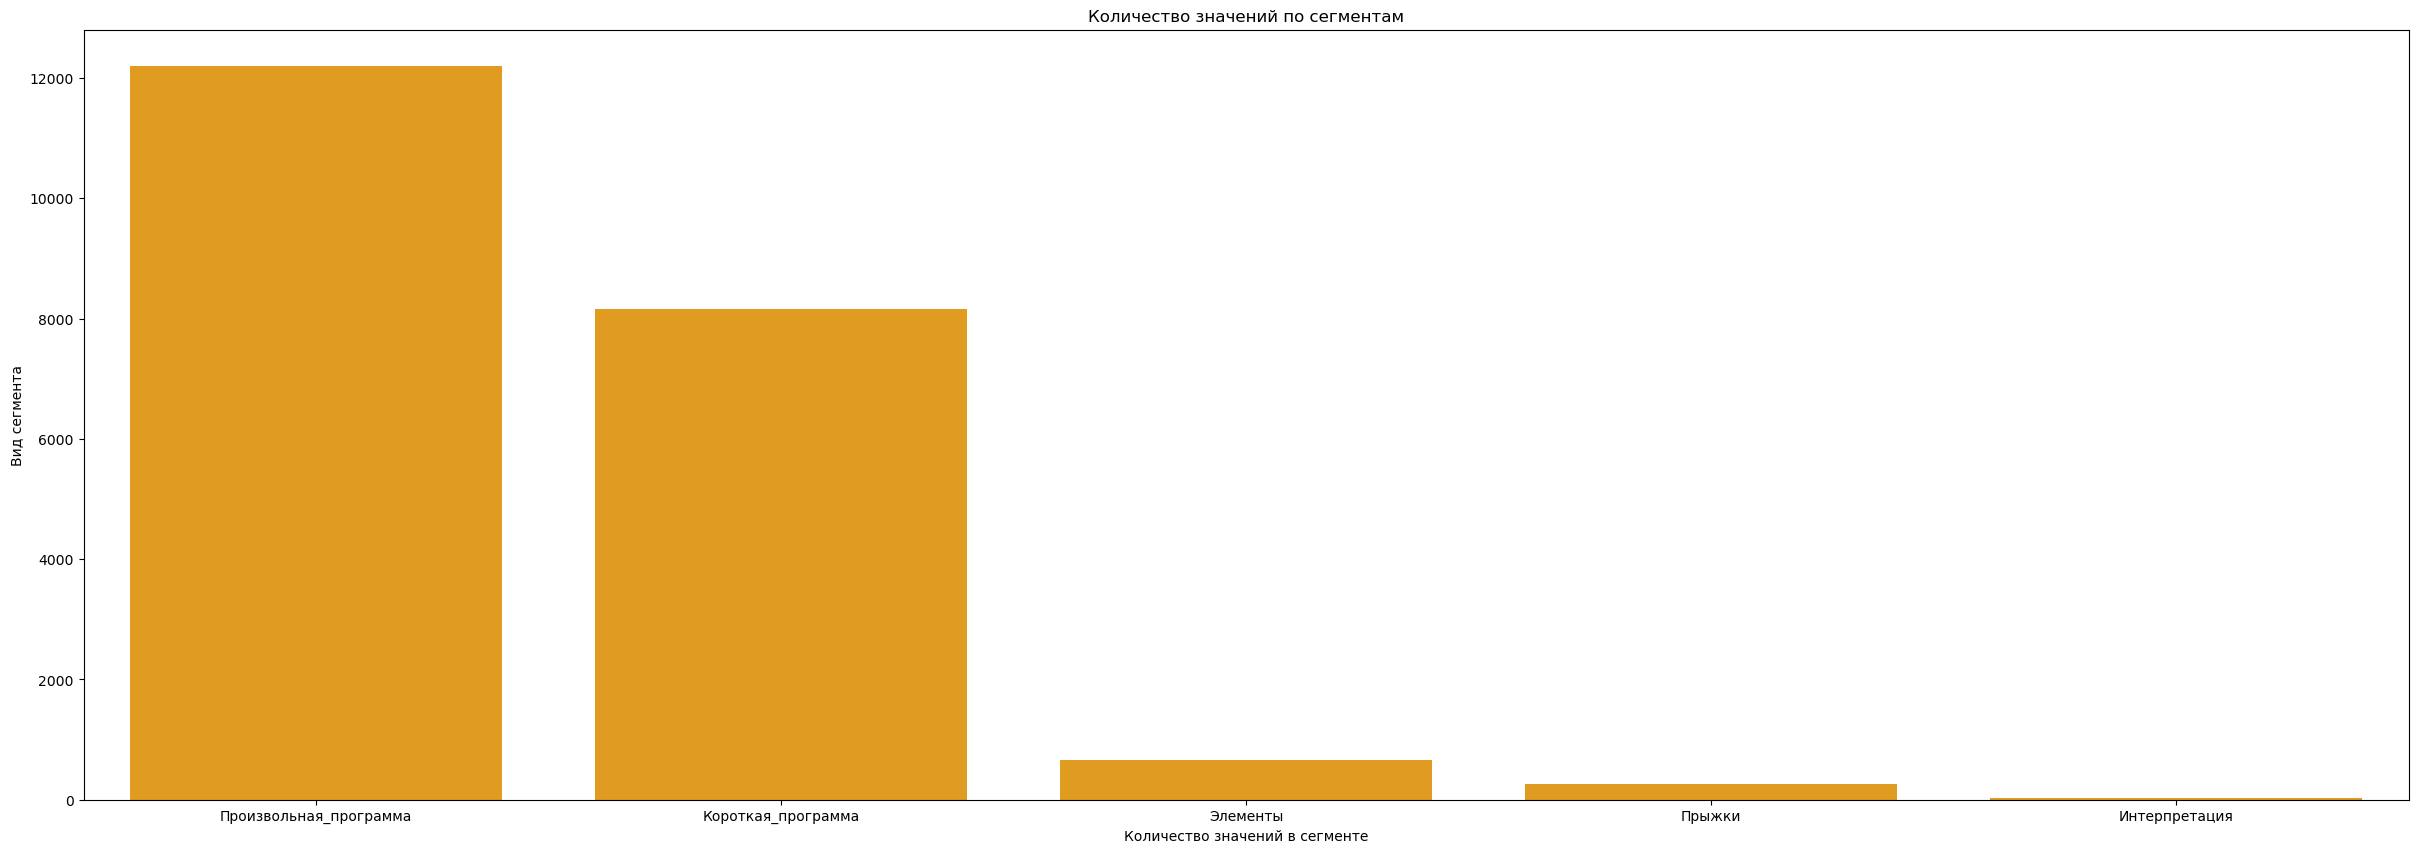

In [20]:
# посмотрим на графике как распределено количество выступлений по сегментам

plt.figure(figsize=(30,10))

sns.barplot(data=segment_vc, x='segment_name', 
            y='count', color='orange')

plt.title('Количество значений по сегментам')
plt.xlabel('Количество значений в сегменте')
plt.ylabel('Вид сегмента')

plt.show()

In [21]:
total_scores.columns

Index(['id', 'unit_id', 'tournament_id', 'base_score', 'components_score',
       'total_score', 'elements_score', 'decreasings_score', 'starting_place',
       'place', 'segment_name', 'info', 'overall_place', 'overall_total_score',
       'overall_place_str'],
      dtype='object')

In [22]:
score_columns = ['base_score', 'components_score', 'total_score', 'elements_score']#, 'decreasings_score']

In [23]:
decrease_vc = pd.DataFrame(total_scores.value_counts('decreasings_score')).reset_index()
decrease_vc

,decreasings_score,count
0,0.0,16803
1,-1.0,2270
2,-0.5,1267
3,-2.0,571
4,-3.0,175
5,-1.5,121
6,-4.0,59
7,-2.5,13
8,-5.0,10
9,-6.0,7


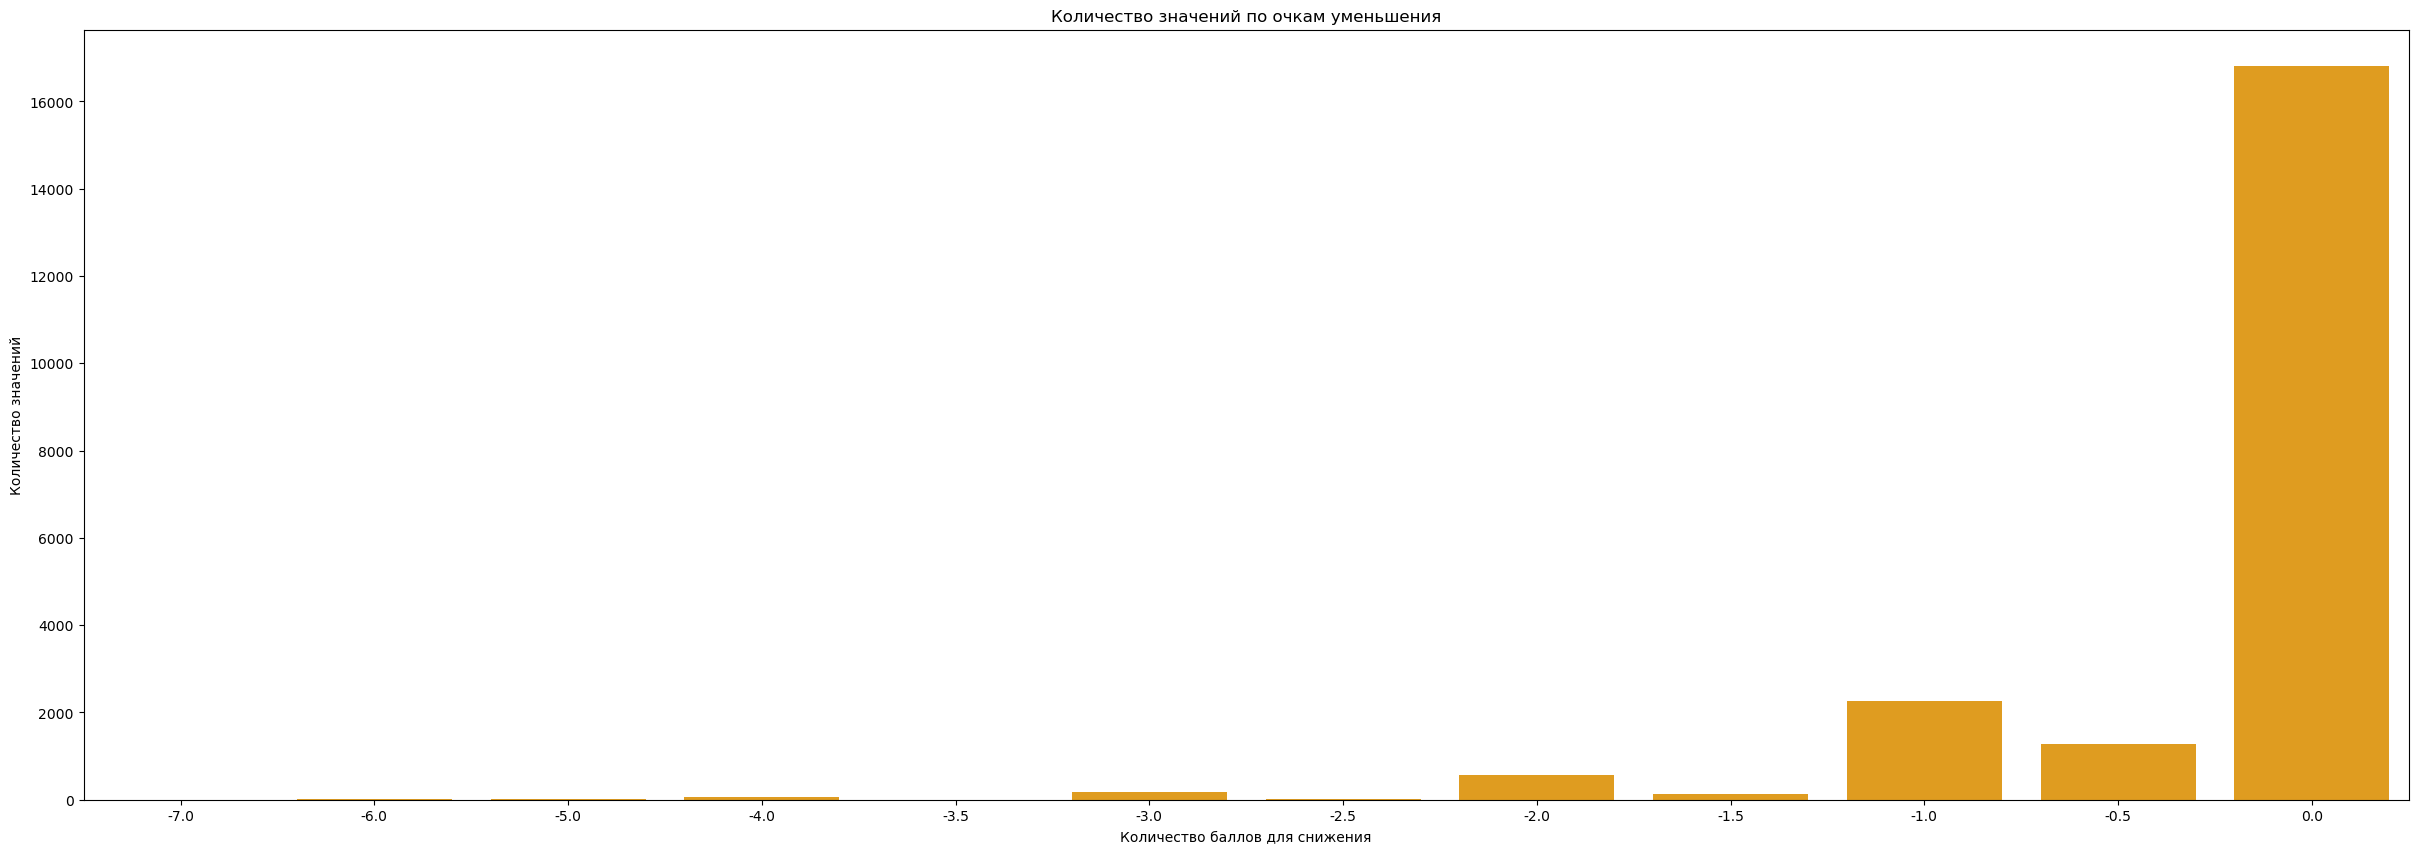

In [24]:
# посмотрим на графике как распределено количество понижающих оценок

plt.figure(figsize=(30,10))

sns.barplot(data=decrease_vc, x='decreasings_score', 
            y='count', color='orange')

plt.title('Количество значений по очкам уменьшения')
plt.xlabel('Количество баллов для снижения')
plt.ylabel('Количество значений')

plt.show()

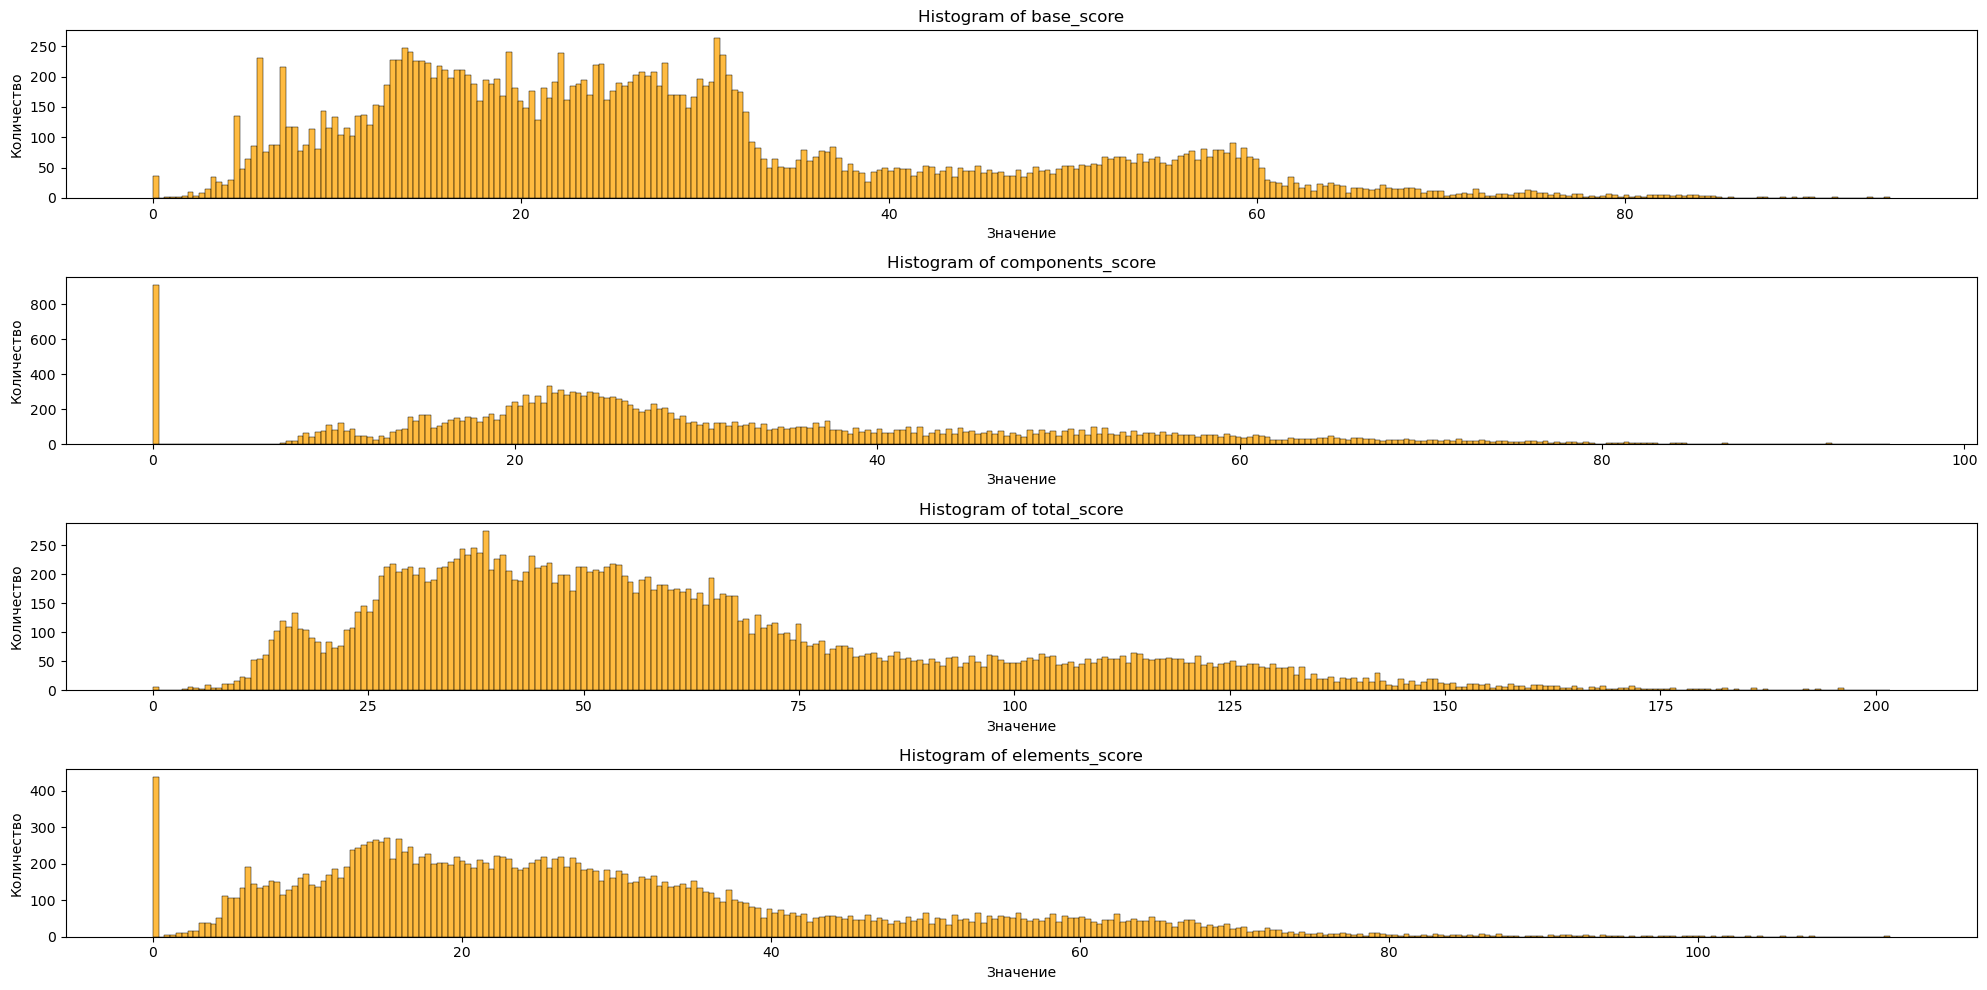

In [25]:
# посмотрим на графике как распределены колонки оценок

fig, ax = plt.subplots(len(score_columns), 1, figsize=(20, 10))

for i in range(len(score_columns)):
    sns.histplot(total_scores[score_columns[i]], ax=ax[i], color='orange', bins=300)
    ax[i].set_title(f'Histogram of {score_columns[i]}')
    ax[i].set_xlabel('Значение')
    ax[i].set_ylabel('Количество')

plt.tight_layout()

plt.show()

In [26]:
for col in score_columns:
    print(f'For col {col} : min value = {min(total_scores[col])} | max value = {max(total_scores[col])}')
    print()

For col base_score : min value = 0.0 | max value = 94.42

For col components_score : min value = 0.0 | max value = 95.9

For col total_score : min value = 0.0 | max value = 201.65

For col elements_score : min value = 0.0 | max value = 112.42



In [27]:
# временные колонки для оценки
score_columns_buckets = ['base_score_buckets', 'components_score_buckets', 'total_score_buckets', 'elements_score_buckets']

In [28]:
# распределим численные данные по корзинкам в 10 единиц
for new_col, old_col in zip(score_columns_buckets, score_columns):
    total_scores[new_col] = total_scores[old_col].apply(lambda x: f"{x // 10 * 10}-{x // 10 * 10 + 10}")

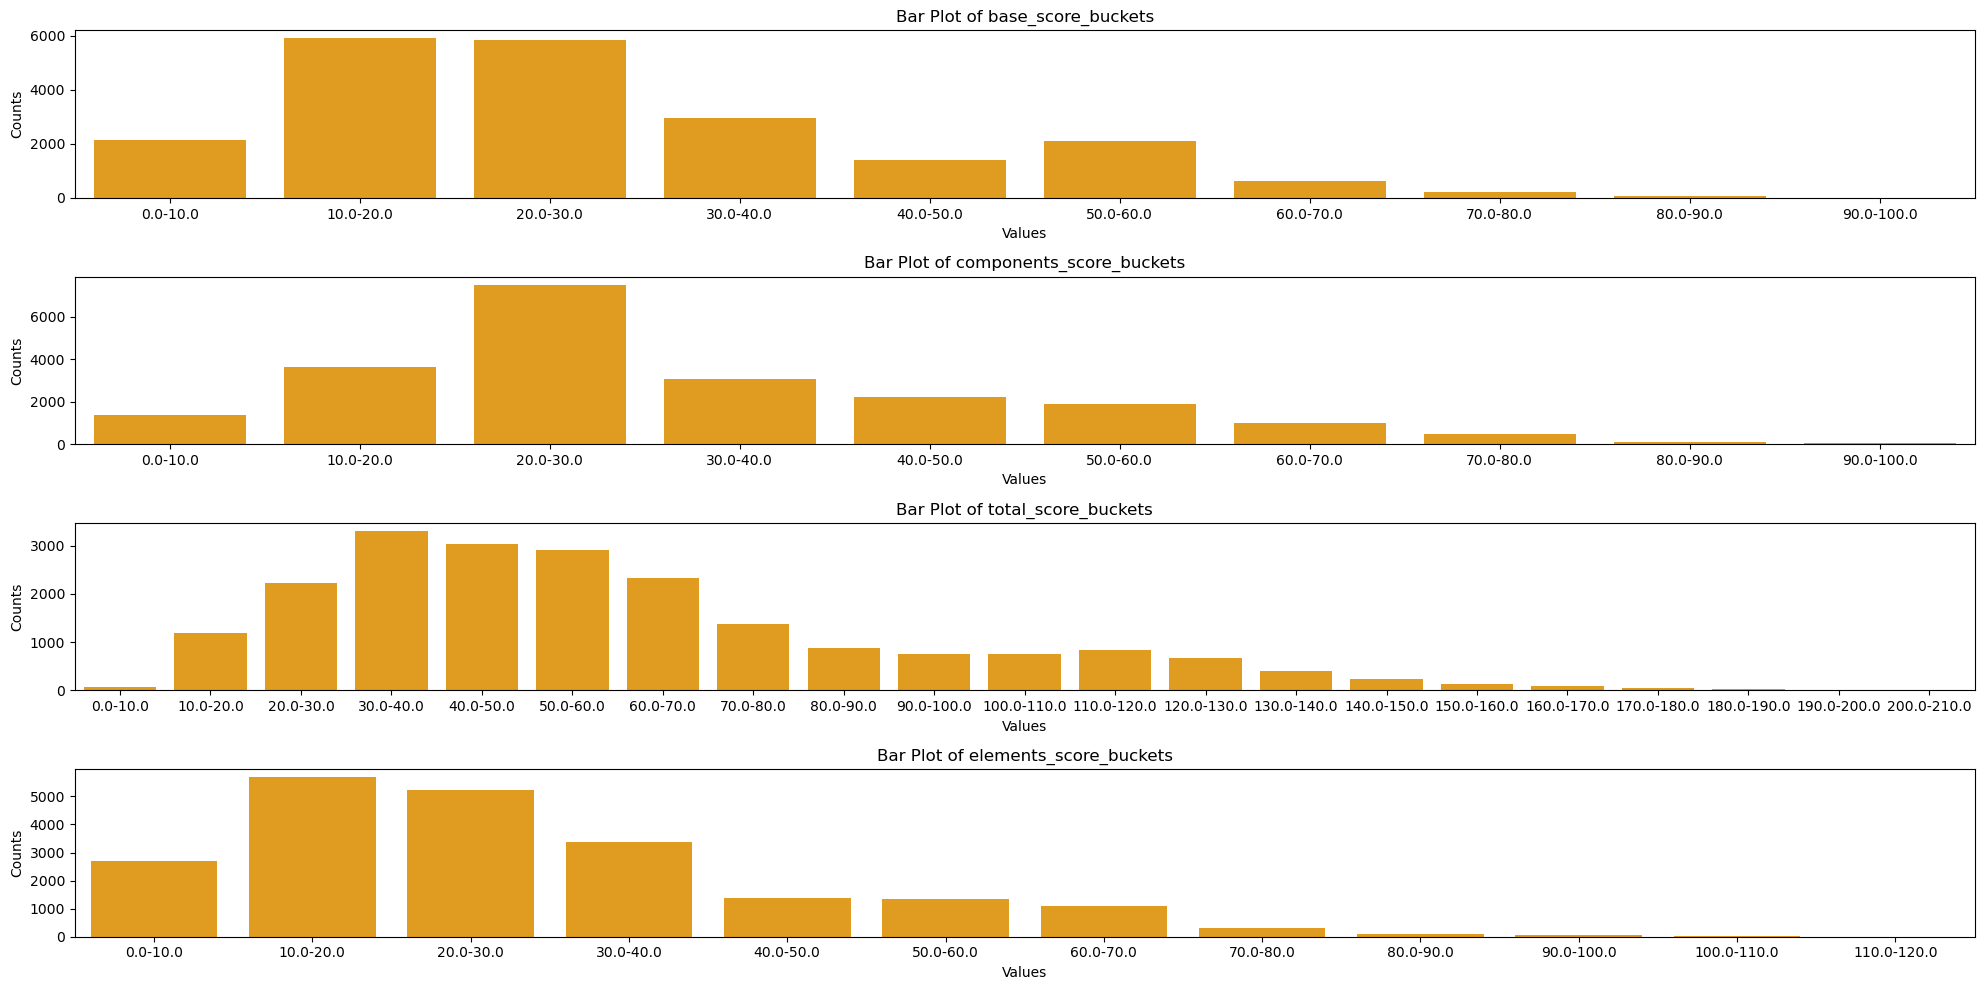

In [29]:
# посмотрим как распределено по "корзинкам"

fig, ax = plt.subplots(len(score_columns_buckets), 1, figsize=(20, 10))

for i in range(len(score_columns_buckets)):
    value_counts = total_scores[score_columns_buckets[i]].value_counts().reset_index()
    value_counts.columns = ['Value', 'Count']
    
    # Sort values by the lower bound of the bucket
    value_counts['lower_bound'] = value_counts['Value'].str.split('-').str[0].astype(float)
    value_counts = value_counts.sort_values('lower_bound').drop(columns='lower_bound')

    sns.barplot(x='Value', y='Count', data=value_counts, ax=ax[i], color='orange')
    ax[i].set_title(f'Bar Plot of {score_columns_buckets[i]}')
    ax[i].set_xlabel('Values')
    ax[i].set_ylabel('Counts')

plt.tight_layout()
plt.show()

## Таблица tour_scores 

In [31]:
custom_eda(tour_scores)

5 случайных строк



,id,total_score_id,title,decrease,base_score,goe,avg_score
56863,65987,12079,FCSp4,NaN,3.20,1.09,4.29
73009,83384,14632,FSSp2V,NaN,1.73,0.29,2.02
29803,35484,7577,3Lze+2T,e,6.02,-1.80,4.22
122767,210729,448170,CCoSp3,NaN,3.00,0.60,3.60
101300,205904,447549,StSq2,NaN,2.60,0.26,2.86


_______________________________________________________

Общая информация по таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              172158 non-null  int64  
 1   total_score_id  172158 non-null  int64  
 2   title           172158 non-null  object 
 3   decrease        41185 non-null   object 
 4   base_score      172158 non-null  float64
 5   goe             172158 non-null  float64
 6   avg_score       172158 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 9.2+ MB


None

_______________________________________________________

Описательная статистика таблицы



,id,total_score_id,base_score,goe,avg_score
count,172158.000000,172158.000000,172158.000000,172158.000000,172158.000000
mean,148848.485444,243100.514156,2.574300,0.131771,3.567541
std,107651.944104,219065.848493,2.151716,0.797761,2.424646
min,1.000000,1.000000,0.000000,-5.750000,0.000000
25%,50613.250000,9385.000000,1.100000,-0.120000,1.980000
50%,158772.500000,442337.000000,2.600000,0.210000,3.250000
75%,223563.750000,449883.750000,3.300000,0.600000,4.200000
max,353806.000000,463639.000000,15.700000,5.060000,23.360000


_______________________________________________________

Количество пропущенных значений

id                0.000000
total_score_id    0.000000
title             0.000000
decrease          0.760772
base_score        0.000000
goe               0.000000
avg_score         0.000000
dtype: float64
_______________________________________________________



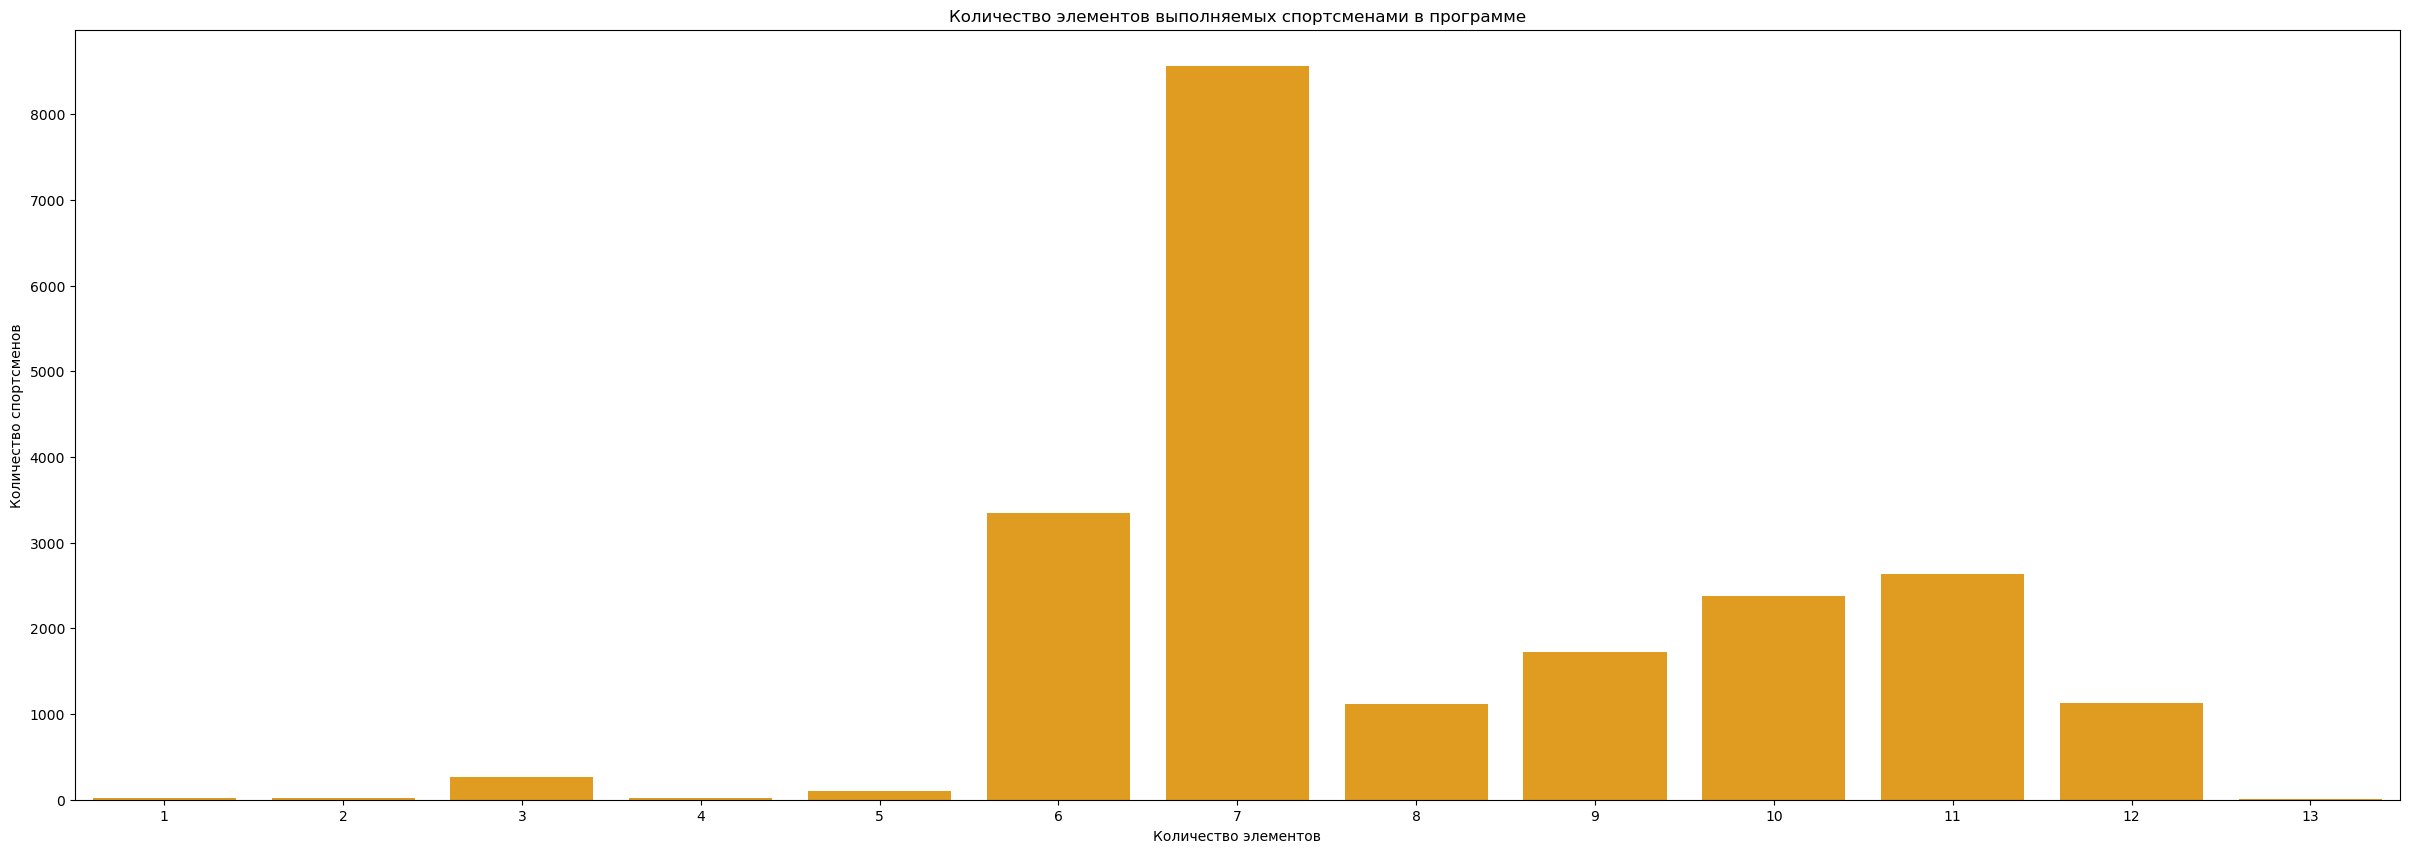

In [32]:
# посмотрим на графике количество элементов в выступлении

plt.figure(figsize=(30,10))

gr_info = tour_scores.value_counts('total_score_id').reset_index()
gr_info.columns = ['id', 'count']
sns.barplot(gr_info.value_counts('count'), color='orange')
plt.title('Количество элементов выполняемых спортсменами в программе')
plt.xlabel('Количество элементов')
plt.ylabel('Количество спортсменов')
plt.show()

Обратим внимание, что большая часть спорстменов выполняет 7 элементов за программу.

## Таблица tour

In [35]:
custom_eda(tour)

5 случайных строк



,id,date_start,date_end,origin_id
35,38,2091-03-06,2091-03-08,2.0
70,93,2089-10-07,2089-10-08,1.0
57,77,2090-12-12,2090-12-16,1.0
15,16,2090-11-28,2090-11-30,2.0
132,7103,2092-03-25,2092-03-28,0.0


_______________________________________________________

Общая информация по таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          142 non-null    int64  
 1   date_start  142 non-null    object 
 2   date_end    142 non-null    object 
 3   origin_id   142 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ KB


None

_______________________________________________________

Описательная статистика таблицы



,id,origin_id
count,142.000000,142.000000
mean,2671.232394,1.380282
std,3129.148777,0.760108
min,1.000000,0.000000
25%,38.250000,1.000000
50%,93.500000,2.000000
75%,6692.500000,2.000000
max,7117.000000,2.000000


_______________________________________________________

Количество пропущенных значений

id            0.0
date_start    0.0
date_end      0.0
origin_id     0.0
dtype: float64
_______________________________________________________



## Таблица units

In [37]:
custom_eda(units)

5 случайных строк



,id,color,school_id
4152,5066,green,62.0
3329,4584,green,192.0
3339,4596,green,192.0
2165,3760,lime,NaN
2837,4395,green,284.0


_______________________________________________________

Общая информация по таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4596 entries, 0 to 4595
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         4596 non-null   int64  
 1   color      4595 non-null   object 
 2   school_id  4007 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 107.8+ KB


None

_______________________________________________________

Описательная статистика таблицы



,id,school_id
count,4596.000000,4007.000000
mean,5016.516971,464.135762
std,7355.726664,5679.988355
min,1.000000,1.000000
25%,1476.750000,62.000000
50%,2953.500000,117.000000
75%,4615.250000,206.000000
max,35024.000000,99999.000000


_______________________________________________________

Количество пропущенных значений

id           0.000000
color        0.000218
school_id    0.128155
dtype: float64
_______________________________________________________



# Создание доп таблицы

## Создание таблицы элементов

In [40]:
jumps = [
    '1T', '1S', '1Lo', '1Eu', '1F', '1Lz', '1A',
    '2T', '2S', '2Lo', '2F', '2Lz', '2A',
    '3T', '3S', '3Lo', '3F', '3Lz', '3A',
    '4T', '4S', '4Lo', '4F', '4Lz', '4A'
]

spins = [
    'USp', 'LSp', 'CSp', 'SSp',
    'FUSp', 'FLSp', 'FCSp', 'FSSp',
    'CUSp', 'CLSp', 'CCSp', 'CSSp',
    'FCUSp', 'FCLSp', 'FCCSp', 'FCSSp',
    'CoSp', 'CCoSp', 'FCoSp', 'FCCoSp'
]

steps = ['StSq', 'ChSq']

clean_ele = jumps + spins + steps

## Предобработка таблицы tour_scores

In [42]:
def delete_last_symb(row):
    symb_2_drop = ['!', '*', '<<', '<']
    
    # Step 1: Replace unwanted symbols in the list
    # row = [item.replace(symb, '') for item in row for symb in symb_2_drop]
    for i in range(len(row)):
        for symb in symb_2_drop:
            if row[i].endswith(symb):
                row[i] = row[i][:-1]

    end_2_drop = ['q', 'e', 'V']
    
    # Step 2: Remove specified ending characters from each word
    for i in range(len(row)):
        for letter in end_2_drop:
            if row[i].endswith(letter):
                row[i] = row[i][:-1]  # Update the word to remove the last letter
                
    return list(set(row))

In [43]:
tour_scores['clean_ele'] = tour_scores['title'].apply(lambda x: x.split('+'))
tour_scores['clean_ele'] = tour_scores['clean_ele'].apply(lambda x: delete_last_symb(x))

# Объединение данных

In [45]:
total_df = total_scores.merge(tour_scores, left_on='id', right_on='total_score_id') \
                        .drop('id_y', axis=1) \
                        .rename(columns={'id_x': 'id'})

total_df = total_df.merge(units, left_on='unit_id', right_on='id') \
                        .drop('id_y', axis=1) \
                        .rename(columns={'id_x': 'id'})

total_df = total_df.merge(tour, left_on='tournament_id', right_on='id') \
                        .drop('id_y', axis=1) \
                        .rename(columns={'id_x': 'id'})

total_df.head(3)

,id,unit_id,tournament_id,base_score_x,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str,base_score_buckets,components_score_buckets,total_score_buckets,elements_score_buckets,total_score_id,title,decrease,base_score_y,goe,avg_score,clean_ele,color,school_id,date_start,date_end,origin_id
0,442027,304,4785,47.2,43.47,102.7,59.23,0.0,17,1,Короткая_программа,x Надбавка за прыжки во второй половине програ...,2,293.74,2,40.0-50.0,40.0-50.0,100.0-110.0,50.0-60.0,442027,4Lz,NaN,11.5,3.78,15.28,[4Lz],lime,62.0,2091-12-20,2091-12-24,2.0
1,442027,304,4785,47.2,43.47,102.7,59.23,0.0,17,1,Короткая_программа,x Надбавка за прыжки во второй половине програ...,2,293.74,2,40.0-50.0,40.0-50.0,100.0-110.0,50.0-60.0,442027,4S+3T,NaN,13.9,2.49,16.39,"[3T, 4S]",lime,62.0,2091-12-20,2091-12-24,2.0
2,442027,304,4785,47.2,43.47,102.7,59.23,0.0,17,1,Короткая_программа,x Надбавка за прыжки во второй половине програ...,2,293.74,2,40.0-50.0,40.0-50.0,100.0-110.0,50.0-60.0,442027,FCSp4,NaN,3.2,0.87,4.07,[FCSp4],lime,62.0,2091-12-20,2091-12-24,2.0


# Подготовка данных

In [47]:
elements = total_df.groupby('unit_id', as_index=False)['clean_ele'].agg(sum)
elements['clean_ele'] = elements.clean_ele.transform(' '.join)
elements

,unit_id,clean_ele
0,1,2A 3F LSp4 2Lo 3Lz FCSp4 StSq2 CCoSp4 3T 2T 3L...
1,3,3F 3Lo 2A FCSp4 3Lz CCoSp4 StSq3 LSp4 2A 2T 3L...
2,4,3T 2Lz CCSp3 StSq2 2A FSSp1 CCoSp4 3Lo 2T 3Lo ...
3,5,2A 3Lo 2T 3Lz CCoSp4 FCSp4 LSp3 StSq3 2A 2T 3F...
4,6,2A 3F 3T CCoSp4 3Lz FSSp4 StSq3 LSp4 3A 2A 3S ...
...,...,...
3388,35003,CCoSp3 1A StSqB 2Lz 2Lo 2T LSp3 1A SЕQ 2Lo 2T ...
3389,35004,1A CCoSp3 2Lo 2T StSqB 2Lz SSp3 1A 2Lz 2T 2S 1...
3390,35005,1A 2Lz SSp3 StSq1 2S 2T CCoSp3 2Lz 1A FSSp2 1A...
3391,35006,2A 2F CCoSp4 StSq1 2Lz 2T FSSp2 LSp3 2A 2T 2A ...


In [48]:
vectorizer = CountVectorizer()

ele_m = pd.DataFrame(
    vectorizer.fit_transform(elements['clean_ele']).toarray(),
    columns = vectorizer.get_feature_names_out()
).drop(columns=['rep', 'seq', 'sеq', 'combo'], axis=1)

ele_m.index = elements.unit_id

In [49]:
ele_m = ele_m.applymap(lambda x: 0 if x == 0 else 1)

In [50]:
ele_m

,1a,1eu,1f,1lo,1lz,1s,1t,1w,2a,2f,2lo,2lz,2s,2t,3a,3f,3lo,3lz,3s,3t,4f,4lo,4lz,4s,4t,ccosp,ccosp1,ccosp2,ccosp3,ccosp4,ccospb,ccsp,ccsp1,ccsp2,ccsp3,ccsp4,ccspb,chs,chspl,chspl1,chsq1,cosp,cosp1,cosp2,cospb,csp,csp1,csp2,csp3,csp4,cspb,cssp,cssp1,cssp2,cssp3,cssp4,csspb,fccosp,fccosp1,fccosp2,fccosp3,fccosp4,fccospb,fccsp4,fcosp,fcosp2,fcsp,fcsp1,fcsp2,fcsp3,fcsp4,fcspb,fcssp,fcssp1,fcssp2,fcssp3,fcssp4,fcsspb,flsp2,flsp3,flsp4,fssp,fssp1,fssp2,fssp3,fssp4,fsspb,fusp1,lo,lsp,lsp1,lsp2,lsp3,lsp4,lspb,lz,sp,ssp,ssp1,ssp2,ssp3,ssp4,sspb,sts,stsq1,stsq2,stsq3,stsq4,stsqb,uspb
unit_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,1,0,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0
3,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0
4,0,1,0,1,0,0,0,0,1,1,1,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0
5,1,1,1,0,1,0,1,0,1,1,1,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0
6,1,1,0,0,0,0,1,0,1,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35003,1,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
35004,1,0,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
35005,1,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


# Построение рекомендательной системы

## Создание базового варианта рекомендательной системы

In [53]:
# Преобразование в разреженную матрицу
sparse_matrix = csr_matrix(ele_m.values)

# Рекомендации для конкретного пользователя
unit_id = 13 

# Получение индекса для user_id = unit_id
user_index = ele_m.index.get_loc(unit_id)

# Получение вектора взаимодействия для пользователя из разреженной матрицы
user_vector = sparse_matrix[user_index]

# Получение рекомендованных объектов
model_1 = AlternatingLeastSquares(factors=5, regularization=0.1, iterations=20)
model_1.fit(sparse_matrix)
recommended_items_1 = model_1.recommend(user_index, user_vector, N=3)
model_2 = AlternatingLeastSquares(factors=10, regularization=0.1, iterations=50)
model_2.fit(sparse_matrix)
recommended_items_2 = model_2.recommend(user_index, user_vector, N=5)
model_3 = AlternatingLeastSquares(factors=15, regularization=0.1, iterations=100)
model_3.fit(sparse_matrix)
recommended_items_3 = model_3.recommend(user_index, user_vector, N=10)

# Печать рекомендованных объектов
print("Рекомендованные объекты 1 для пользователя:", recommended_items_1)
print("Рекомендованные объекты 2 для пользователя:", recommended_items_2)
print("Рекомендованные объекты 3 для пользователя:", recommended_items_3)

recommended_item_ids_1 = ele_m.columns[recommended_items_1[0]]
recommended_item_ids_2 = ele_m.columns[recommended_items_2[0]]
recommended_item_ids_3 = ele_m.columns[recommended_items_3[0]]

print("Рекомендованные объекты 1 для пользователя:", set(recommended_item_ids_1.to_list()))
print("Рекомендованные объекты 2 для пользователя:", set(recommended_item_ids_2.to_list()))
print("Рекомендованные объекты 3 для пользователя:", set(recommended_item_ids_3.to_list()))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Рекомендованные объекты 1 для пользователя: (array([27, 83, 84], dtype=int32), array([0.7623851 , 0.53405195, 0.5156273 ], dtype=float32))
Рекомендованные объекты 2 для пользователя: (array([ 54,  68,  18, 105,  70], dtype=int32), array([0.5160657 , 0.4695225 , 0.4347438 , 0.3050719 , 0.25549936],
      dtype=float32))
Рекомендованные объекты 3 для пользователя: (array([ 54,  68,  18,  70, 105,  82,  67,  19,  60, 100], dtype=int32), array([0.521707  , 0.45764425, 0.39536035, 0.25562078, 0.22954045,
       0.20314033, 0.20062274, 0.19739784, 0.14004244, 0.13348672],
      dtype=float32))
Рекомендованные объекты 1 для пользователя: {'ccosp2', 'fssp2', 'fssp3'}
Рекомендованные объекты 2 для пользователя: {'3s', 'fcsp2', 'cssp3', 'stsq2', 'fcsp4'}
Рекомендованные объекты 3 для пользователя: {'3s', 'fcsp2', 'ssp3', '3t', 'fssp1', 'fccosp3', 'cssp3', 'fcsp1', 'stsq2', 'fcsp4'}


In [54]:
total_recs = list(set((recommended_item_ids_1.to_list()) + (recommended_item_ids_2.to_list()) + (recommended_item_ids_3.to_list())))
# total_recs

In [55]:
rec_dict = {}

for i in total_recs:
    # Фильтруем оценки
    filtered_scores = scores.loc[scores['element'].str.contains(i, case=False), 'base']
    
    # Проверяем, есть ли у нас оценки и пытаемся сохранить максимальную
    if not filtered_scores.empty:  # Если оценки не пустые
        max_score = max(filtered_scores)  # Получаем максимальную оценку
        rec_dict.setdefault(i, max_score)  # Добавляем в словарь
                
    # Если с текущим i произошла ошибка, пробуем i без последнего символа
    else:
        i_new = i[:-1]
        filtered_scores_new = scores.loc[scores['element'].str.contains(i_new, case=False), 'base']
        
        if not filtered_scores_new.empty:
            max_score = max(filtered_scores_new)
            rec_dict.setdefault(i_new, max_score)
        else:
            # Пробуем i без первого символа
            i_new = i[1:]
            filtered_scores_new = scores.loc[scores['element'].str.contains(i_new, case=False), 'base']
            
            if not filtered_scores_new.empty:
                max_score = max(filtered_scores_new)
                rec_dict.setdefault(i_new, max_score)

rec_dict = {key: float(value) for key, value in rec_dict.items()}
print(rec_dict)

{'3s': 4.4, 'fssp3': 2.6, 'fcsp2': 2.3, 'ssp3': 2.6, 'ccosp2': 2.5, 'fssp2': 2.3, '3t': 6.0, 'fssp1': 2.0, 'ccosp3': 3.0, 'cssp3': 2.6, 'fcsp1': 1.9, 'stsq2': 2.6, 'fcsp4': 3.2}


In [56]:
last_pr_dict = {}

columns_with_one = ele_m[ele_m.index == unit_id].any(axis=0)
filtered_columns = ele_m.columns[columns_with_one]

for i in filtered_columns:
    # Фильтруем оценки
    filtered_scores = scores.loc[scores['element'].str.contains(i, case=False), 'base']
    
    # Проверяем, есть ли у нас оценки и пытаемся сохранить максимальную
    if not filtered_scores.empty:  # Если оценки не пустые
        max_score = max(filtered_scores)  # Получаем максимальную оценку
        last_pr_dict.setdefault(i, max_score)  # Добавляем в словарь
                
    # Если с текущим i произошла ошибка, пробуем i без последнего символа
    else:
        i_new = i[:-1]
        filtered_scores_new = scores.loc[scores['element'].str.contains(i_new, case=False), 'base']
        
        if not filtered_scores_new.empty:
            max_score = max(filtered_scores_new)
            last_pr_dict.setdefault(i_new, max_score)
        else:
            # Пробуем i без первого символа
            i_new = i[1:]
            filtered_scores_new = scores.loc[scores['element'].str.contains(i_new, case=False), 'base']
            
            if not filtered_scores_new.empty:
                max_score = max(filtered_scores_new)
                last_pr_dict.setdefault(i_new, max_score)

last_pr_dict = {key: float(value) for key, value in last_pr_dict.items()}
print(last_pr_dict) 

{'1a': 2.2, '1eu': 0.5, '2a': 4.0, '2f': 3.0, '2lo': 2.8, '2lz': 3.0, '2s': 2.5, '2t': 3.4, 'ccosp3': 3.0, 'ccosp4': 3.5, 'chsq': 3.0, 'cssp2': 2.3, 'cssp4': 3.0, 'ccosp2': 2.5, 'fcsp3': 2.8, 'stsq1': 1.8, 'stsqb': 1.5}


In [57]:
mean_score_prog = np.mean([float(i) for i in last_pr_dict.values()])
mean_score_prog

2.635294117647059

In [58]:
last_rec = {}


for rec, rec_score in rec_dict.items():
    for ele in last_pr_dict.keys():
        # Убедитесь, что сравнение возможно
        if rec != ele and rec_score > mean_score_prog:
            last_rec.setdefault(rec, [rec_score])


print(last_rec)

{'3s': [4.4], '3t': [6.0], 'ccosp3': [3.0], 'fcsp4': [3.2]}


In [59]:
print(f'Для спортсмена под номером {unit_id} рекомедовенно рассмотреть добавление в программу элементов, которые потенциально увеличат среднюю оценку за выполненные элементы:')
for key, value in last_rec.items():
    print(f'Элемент {key}, стоимость элемента составляет {value}')

Для спортсмена под номером 13 рекомедовенно рассмотреть добавление в программу элементов, которые потенциально увеличат среднюю оценку за выполненные элементы:
Элемент 3s, стоимость элемента составляет [4.4]
Элемент 3t, стоимость элемента составляет [6.0]
Элемент ccosp3, стоимость элемента составляет [3.0]
Элемент fcsp4, стоимость элемента составляет [3.2]


## Создание класса предсказания

In [61]:
class GoProtectRecSys:
    def __init__(self, s_matrix, score_df, ele_df, user_id: int, verbose=False):
        self.s_matrix = s_matrix
        self.user_id = user_id
        self.score_df = score_df
        self.ele_df = ele_df
        self.verbose = verbose
        self.last_performance_list = []
        self.mean_last_performance = 0
        self.predict_dict = None
        self.user_rec = None
        self.final_rec = None

        # Automatic call to last_performance during initialization
        self.last_performance()

    def last_performance(self):
        last_pr_dict = {}

        columns_with_one = self.ele_df[self.ele_df.index == self.user_id].any(axis=0)
        filtered_columns = self.ele_df.columns[columns_with_one]

        for element in filtered_columns:
            filtered_scores = self.score_df.loc[self.score_df['element'].str.contains(element, case=False), 'base']

            if not filtered_scores.empty:
                max_score = max(filtered_scores)
                last_pr_dict[element] = float(max_score)
            else:
                for new_element in [element[:-1], element[1:]]:
                    filtered_scores_new = self.score_df.loc[self.score_df['element'].str.contains(new_element, case=False), 'base']
                    if not filtered_scores_new.empty:
                        max_score = max(filtered_scores_new)
                        last_pr_dict[new_element] = float(max_score)
                        break  # Stop loop upon finding first suitable element

        # Update instance variables based on results from last_pr_dict
        self.last_performance_list = list(last_pr_dict.keys())
        
        # Calculate mean only if there are values in last_pr_dict
        if last_pr_dict:
            self.mean_last_performance = np.round(np.mean(list(last_pr_dict.values())), 2)
        else:
            self.mean_last_performance = 0

    def fit_predict(self):
        try:
            user_index = self.ele_df.index.get_loc(self.user_id)
        except KeyError:
            print(f"User ID {self.user_id} not found.")
            return None
    
        user_vector = self.s_matrix[user_index]
        
        model_list = [
            (AlternatingLeastSquares(factors=5, regularization=0.1, iterations=20), 3), 
            (AlternatingLeastSquares(factors=10, regularization=0.1, iterations=50), 5), 
            (AlternatingLeastSquares(factors=15, regularization=0.1, iterations=100), 10)
        ]
        
        model_predict = {}
        
        for n, (model, num_recommendations) in enumerate(model_list):
            model.fit(self.s_matrix)
            rec_elems = model.recommend(user_index, user_vector, N=num_recommendations)    
            rec_items = self.ele_df.columns[rec_elems[0]]
            model_predict[f'model_{n + 1}'] = rec_items.tolist()
        
        self.predict_dict = model_predict

        if self.verbose:
            print(model_predict)

    def get_rec(self):
        if self.predict_dict == None:
            self.fit_predict()

        model_predict = self.predict_dict
        all_values = list(set([item for sublist in model_predict.values() for item in sublist]))

        rec_dict = {}

        for i in all_values:
            # Фильтруем оценки
            filtered_scores = self.score_df.loc[self.score_df['element'].str.contains(i, case=False), 'base']
            
            # Проверяем, есть ли у нас оценки и пытаемся сохранить максимальную
            if not filtered_scores.empty:  # Если оценки не пустые
                max_score = max(filtered_scores)  # Получаем максимальную оценку
                rec_dict.setdefault(i, max_score)  # Добавляем в словарь
                        
            # Если с текущим i произошла ошибка, пробуем i без последнего символа
            else:
                i_new = i[:-1]
                filtered_scores_new = scores.loc[scores['element'].str.contains(i_new, case=False), 'base']
                
                if not filtered_scores_new.empty:
                    max_score = max(filtered_scores_new)
                    rec_dict.setdefault(i_new, max_score)
                else:
                    # Пробуем i без первого символа
                    i_new = i[1:]
                    filtered_scores_new = scores.loc[scores['element'].str.contains(i_new, case=False), 'base']
                    
                    if not filtered_scores_new.empty:
                        max_score = max(filtered_scores_new)
                        rec_dict.setdefault(i_new, max_score)
        
        rec_dict = {key: float(value) for key, value in rec_dict.items()}
        # print(rec_dict)

        final_rec = {}

        for rec, rec_score in rec_dict.items():
            for ele in last_pr_dict.keys():
                # Убедитесь, что сравнение возможно
                if rec != ele and rec_score > self.mean_last_performance:
                    final_rec.setdefault(rec, [rec_score])

        self.final_rec = final_rec

        return final_rec

    def print_rec(self):
        if self.final_rec == None:
            self.get_rec()
            
        print(f'''
Для пользователя id: {user_rec_sys_instance.user_id}

Последняя программа выступления была: {user_rec_sys_instance.last_performance_list}

Средняя оценка элемента за программу составила {user_rec_sys_instance.mean_last_performance}

Рекомендованные элементы для рассмотрения:''')
        
        for k, v in self.final_rec.items():
            print(f'Элемент {k} с базовой оценкой {v}')

In [62]:
# Пример использования класса (не забудьте передать правильные аргументы):
user_rec_sys_instance = GoProtectRecSys(s_matrix=sparse_matrix,
                                          score_df=scores,
                                          ele_df=ele_m,
                                          user_id=unit_id,
                                          # verbose=True
                                       )

In [63]:
user_rec_sys_instance.fit_predict()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [64]:
user_rec = user_rec_sys_instance.get_rec()

In [65]:
user_rec_sys_instance.print_rec()


Для пользователя id: 13

Последняя программа выступления была: ['1a', '1eu', '2a', '2f', '2lo', '2lz', '2s', '2t', 'ccosp3', 'ccosp4', 'chsq', 'cssp2', 'cssp4', 'ccosp2', 'fcsp3', 'stsq1', 'stsqb']

Средняя оценка элемента за программу составила 2.64

Рекомендованные элементы для рассмотрения:
Элемент 3s с базовой оценкой [4.4]
Элемент 3t с базовой оценкой [6.0]
Элемент ccosp3 с базовой оценкой [3.0]
Элемент fcsp4 с базовой оценкой [3.2]


In [66]:
random_users = random.sample(list(total_scores.unit_id.unique()), 5)

In [67]:
for user in random_users:
    print(f'Для спортсмена {user}')
    print()
    user_rec_sys_instance = GoProtectRecSys(s_matrix=sparse_matrix,
                                          score_df=scores,
                                          ele_df=ele_m,
                                          user_id=user,
                                          # verbose=True
                                       )

    user_rec_sys_instance.print_rec()
    print('************************************************************')

Для спортсмена 1526



  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Для пользователя id: 1526

Последняя программа выступления была: ['2a', '2f', '2lo', '2lz', '2t', '3s', 'ccosp3', 'chsq', 'fssp4', 'lsp3', 'lsp4', 'stsq2']

Средняя оценка элемента за программу составила 3.19

Рекомендованные элементы для рассмотрения:
Элемент ccosp4 с базовой оценкой [3.5]
Элемент 3t с базовой оценкой [6.0]
Элемент 3lo с базовой оценкой [5.0]
************************************************************
Для спортсмена 1856



  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Для пользователя id: 1856

Последняя программа выступления была: ['1a', '1lo', '2f', '2lo', '2lz', '2s', '2t', 'ccosp2', 'ccosp3', 'chsq', 'fssp', 'fssp1', 'fssp2', 'fssp3', 'ssp3', 'stsqb']

Средняя оценка элемента за программу составила 2.55

Рекомендованные элементы для рассмотрения:
Элемент 2a с базовой оценкой [4.0]
************************************************************
Для спортсмена 2877



  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Для пользователя id: 2877

Последняя программа выступления была: ['1a', '1f', '1lo', '1lz', 'csp', 'cspb', 'sspb']

Средняя оценка элемента за программу составила 1.86

Рекомендованные элементы для рассмотрения:
Элемент ccosp4 с базовой оценкой [3.5]
Элемент 2s с базовой оценкой [2.5]
Элемент cssp с базовой оценкой [3.0]
Элемент ccosp3 с базовой оценкой [3.0]
Элемент chsq с базовой оценкой [3.0]
Элемент ssp с базовой оценкой [3.0]
************************************************************
Для спортсмена 1790



  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Для пользователя id: 1790

Последняя программа выступления была: ['1a', '1f', '1lo', '1lz', '2f', '2lo', '2lz', '2s', '2t', 'ccosp', 'ccosp1', 'ccosp3', 'chsq', 'csp', 'csspb', 'fssp2', 'sspb', 'stsqb']

Средняя оценка элемента за программу составила 2.38

Рекомендованные элементы для рассмотрения:
Элемент fssp3 с базовой оценкой [2.6]
Элемент ssp3 с базовой оценкой [2.6]
Элемент ccosp2 с базовой оценкой [2.5]
Элемент cssp с базовой оценкой [3.0]
Элемент 2a с базовой оценкой [4.0]
************************************************************
Для спортсмена 4656



  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Для пользователя id: 4656

Последняя программа выступления была: ['1f', '1lo', '1lz', 'csp', 'sspb']

Средняя оценка элемента за программу составила 1.82

Рекомендованные элементы для рассмотрения:
Элемент cssp с базовой оценкой [3.0]
Элемент 1a с базовой оценкой [2.2]
Элемент 2lz с базовой оценкой [3.0]
Элемент ssp с базовой оценкой [3.0]
Элемент cssp1 с базовой оценкой [1.9]
************************************************************
